# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [4]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/home/fang/projects/udacity-deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Algorithm description

The training of action-critic algorithm iterates the following flow:

* Gerante the experience tuples from interaction of agent to environment and save to a common replay buffer
* Sample a batch from replay buffer for learning (if the replay buffer is large enough)
* Update the critic:
    1. Get the action by feeding state into target actor 
    2. Get the action-value of next state/next action pair `Q_next`
    3. Update the 'actual' Q value for the current state/action pair as $Q\_current = r + \gamma*Q\_next$
    4. Feed the current state and current action into the local critic to get `Q_pred`
    5. Compute the MSE loss between `Q_current` and `Q_predicted`, and update the weights of the local critic
* Update the actor:
    1. Get the predicted actions for the current states based on the local actor
    2. Get the `Q-values` (expected reward) of these by passing the current states and predicted actions through the local critic
    3. Use the negative mean of the `Q-values` as a loss to update the weights of the local actor
    4. Update the actor and critic target network weights with soft update
    
Actor model:
```
layer1: Linear(in_features=33, out_features=400, bias=True) with activation relu
layer2: Linear(in_features=400, out_features=300, bias=True) with activation relu
layer3: Linear(in_features=200, out_features=4, bias=True) with activation tanh
```

Critic model:
```
layer1: Linear(in_features=33, out_features=400, bias=True) 
layer2: Linear(in_features=400, out_features=300, bias=True)
layer3: Linear(in_features=200, out_features=1, bias=True) with activation relu
```

In [7]:
from ddpg_agents import Agents
from collections import deque
import torch
import os
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size 
state_size = env_info.vector_observations.shape[1]


def multi_ddpg(agents, max_t = 1000, n_episodes=600):
    """ Deep Deterministic Policy Gradient for two agents"""
    print_every = 100

    scores_deque = deque(maxlen=print_every)
    scores = []
    mean_scores = []
    threshold = 0.5
    actor_local = None
    critic_local = None
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations

        agents.reset() # set the noise to zero
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            # choose actions
            actions = agents.act(states) 
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations             
            rewards = env_info.rewards                              
            dones = env_info.local_done                            
            # take action 
            agents.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break

        scores_deque.append(np.max(score)) 
        scores.append(np.max(score))
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        mean_score = np.mean(scores_deque)
        mean_scores.append(mean_score)
        if mean_score > threshold:
            actor_local = agents.actor_local.state_dict()
            critic_local = agents.critic_local.state_dict()
            break
            
    torch.save(actor_local, 'checkpoint_actor.pth')
    torch.save(critic_local, 'checkpoint_critic.pth')
    return scores, mean_scores

### Train the agent
Parameters:
 
 ```buffer_size=int(1e5), batch_size=128, gamma = 0.99, tau = 0.02,
 lr_actor=1e-3, lr_critic=1e-3, weight_decay=0```

In [8]:
agent = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=12)
scores, mean_scores = multi_ddpg(agent)

Episode 100	Average Score: 0.016
Episode 200	Average Score: 0.035
Episode 297	Average Score: 0.514

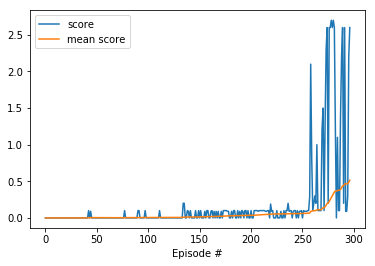

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_plot(scores, mean_scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    p1 = plt.plot(np.arange(len(scores)), scores)
    p2 = plt.plot(np.arange(len(scores)), mean_scores)
    plt.legend((p1[0], p2[0]), ('score', 'mean score'))

    plt.xlabel('Episode #')
    plt.show()
show_plot(scores, mean_scores)

In [7]:
# Watch how the trained Agent performs in the environment
agent = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=12)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)       # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.5000000074505806


### Future work
* The performance of DDPG decreases after some episode of training. Better model is needed for stable training and learning.
* The Grid search for hyperparameter is not so efficient. One idea is to use bayesian parameter estimation, search for a optimal hyperparameter distribution instead of trying each hyperparameter combination